# Whirlpool Galaxy spectrum reduction

Author: Lehman Garrison (http://lgarrison.github.io)

Basic spectral reduction for M51 from the Clay Telescope slit spectrograph from a 10 minute exposure from the 3/6/2019 HOP session.

In [1]:
# Some preamble

from astropy.io import fits

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

def show_image(data, vmin=None, vmax=150, nbars=0, labels=True):
    fig, ax = plt.subplots(figsize=(14,10))
    ax.set_aspect('equal')
    axim = ax.imshow(data, interpolation='none', vmax=vmax, vmin=vmin)

    for i in range(1,nbars):
        ax.axvline(data.shape[-1]/nbars*i, c='k')
        
    if labels:
        ax.set_xlabel('Wavelength')
        ax.set_ylabel('Position along slit')

    fig.colorbar(axim, fraction=0.046, pad=0.04)
    
    return ax

## CCD image

This is the image we took with the main CCD.  We slightly repositioned the telescope after this to center M51 better before switching to the spectrograph.

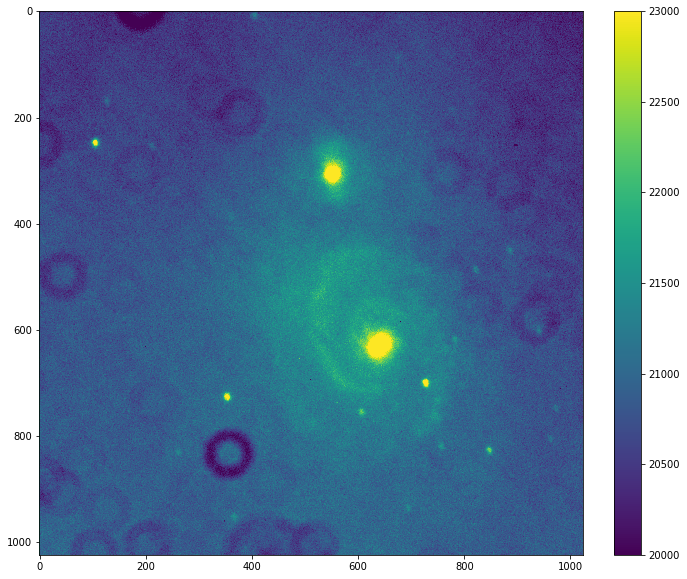

In [2]:
with fits.open('whirlpool_ccd.fit') as hdul:
    ccd_image = hdul[0]
    show_image(ccd_image.data, vmin=20e3, vmax=23e3, labels=False)

## Spectrograph tracker

This is a (quick) image we took from the spectrograph tracking CCD before switching to the slit imager.  It's very hard to tell, but it seems likely that the two blobs are M51 and its companion.

Next time, it would probably be worth doing a longer exposure here.

Also maybe there's an insect on the optical path...?

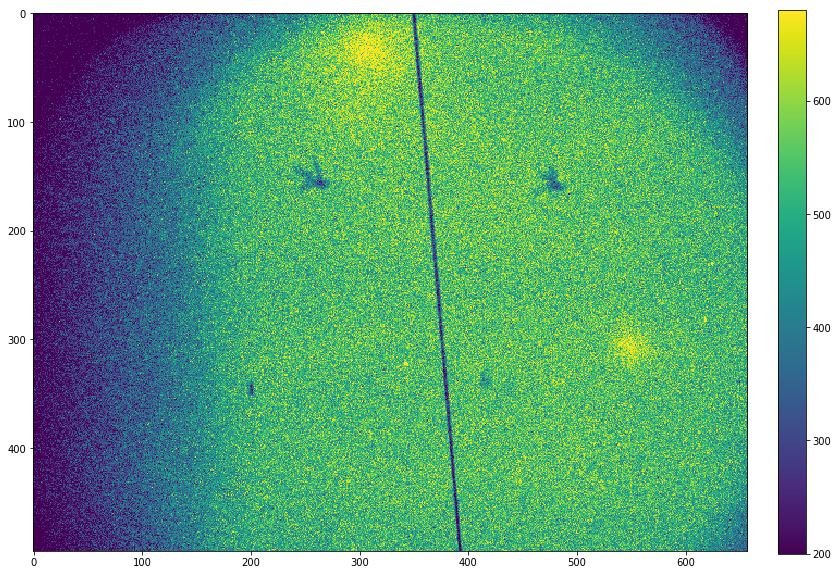

In [3]:
with fits.open('whirlpool_spectrograph_tracking.fit') as hdul:
    tracker_image = hdul[0]
    show_image(tracker_image.data, vmin=200, vmax=680, labels=False)

## Raw spectrum from slit imager

Now let's load the raw spectrum from the 10 min spectrograph exposure

Load the data:

In [4]:
hdul = fits.open('whirlpool_spectrograph_imaging.fit')
image = hdul[0]

In [5]:
image.header

SIMPLE  =                    T /                                                
BITPIX  =                   16 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                  765 /                                                
NAXIS2  =                  510 /                                                
OBJECT  = '        '           /                                                
TELESCOP= 'Clay Telescope'                                                      
INSTRUME= 'SBIG ST-7'                                                           
OBSERVER= 'S-35    '                                                            
DATE-OBS= '2019-03-07T02:07:31.000' / GMT START OF EXPOSURE                     
BZERO   = +3.276800000000E+004 /                                                
BSCALE  = +1.000000000000E+000 /                                                
EXPTIME = +6.000000000000E+0

View the raw data:

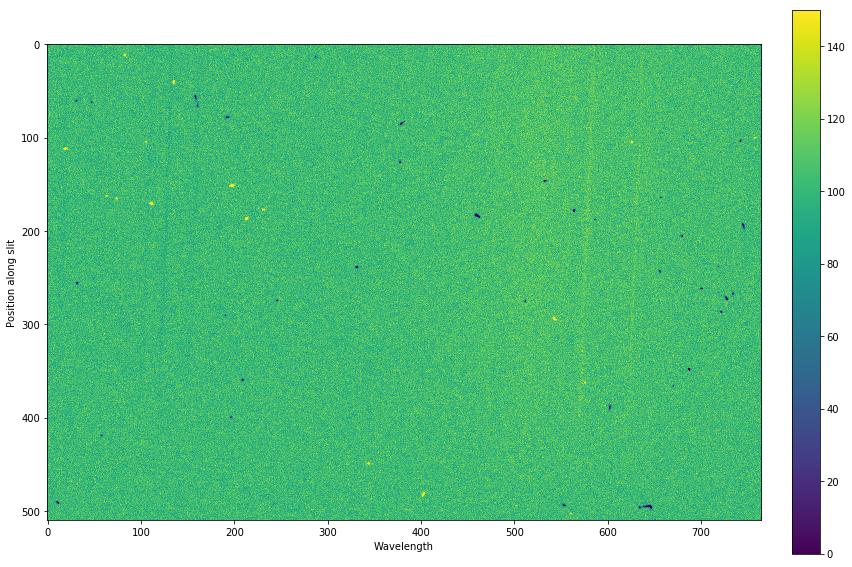

In [6]:
show_image(image.data)

We see some (faint) lines!  We can stack these to get more signal-to-noise at the cost of spatial information.

There are two obvious issues we need to tackle first: the specks of noise (cosmic rays...?) and the tilt of the slit relative to the CCD pixels.  The former will show up as noise or false lines in the spectrum, as their equivalent widths are quite high.  The latter just makes the stacking harder.

### Mask the noise

The specks of noise show up as high or low fluctuations in the histogram of counts.  There's a big Poissonian bump—that's our signal—so we can probably clip the pixels around it.

In [7]:
plt.hist(image.data.flat, log=True, bins=image.data.max()+1);
plt.xlabel('Pixel value')
plt.ylabel('Histogram')

Text(0,0.5,'Histogram')

In [8]:
import numpy.ma as ma

def noise_filter(image, vmin=55, vmax=150):
    image = ma.masked_array(image)
    image.mask |= image < vmin
    image.mask |= image > vmax
    
    return image

im1 = image.data.copy()
im1 = noise_filter(im1)

We did a pretty good job of masking the bad pixels, which now appear in white in the image below.  The histogram agrees.

Text(0,0.5,'Histogram')

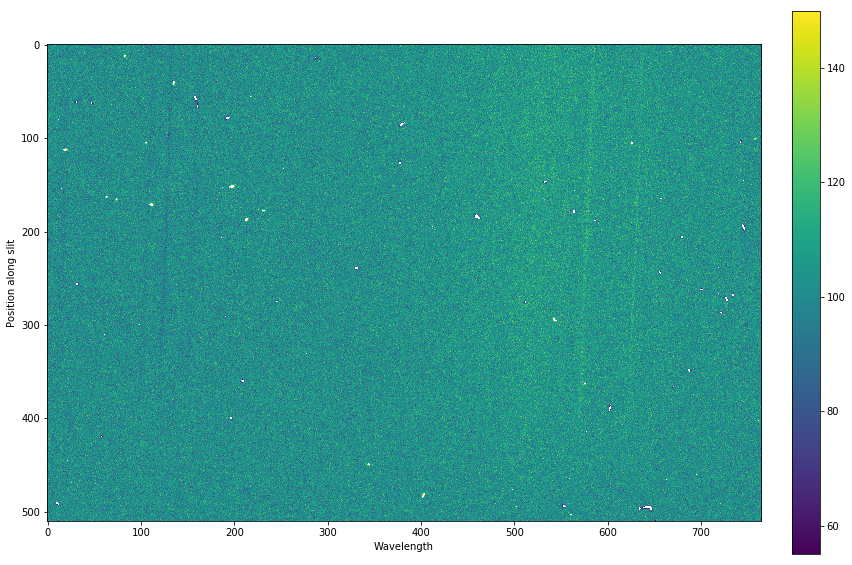

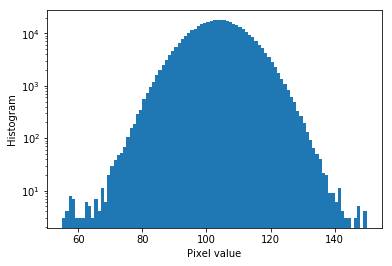

In [9]:
show_image(im1)

plt.figure()
plt.hist(im1.reshape(-1), log=True, bins=95);
plt.xlabel('Pixel value')
plt.ylabel('Histogram')

### Rotate image

Let's draw some vertical lines on the image to manually align the pixels.

We'll use `scipy`'s spline rotation, but the "right" way to do this is probably drizzling.

To determine the "right" rotation angle, we measure the angle of the slit in the tracking image above.  But 2 degrees seems really close here, though.

The rotation seems to get rid of the mask, so let's re-mask after.

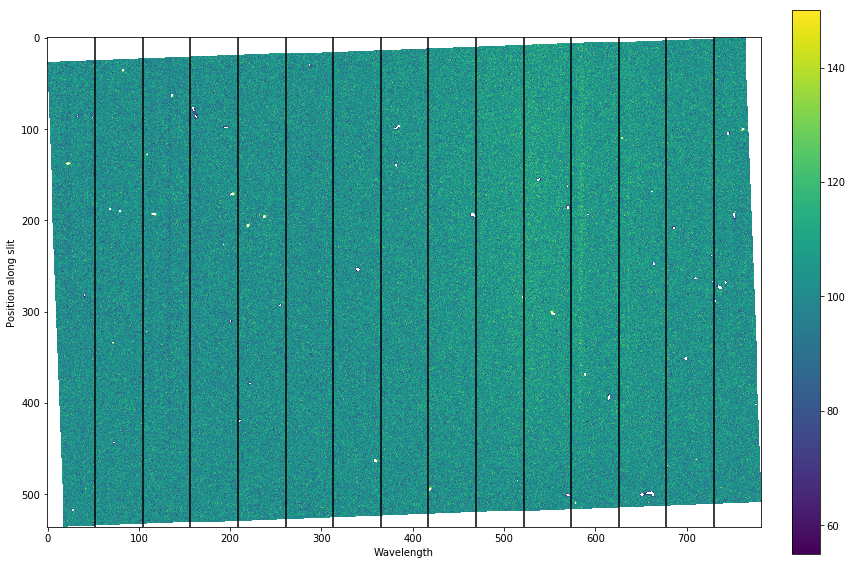

In [10]:
import scipy.ndimage
def rotate(image, angle=2.):
    return scipy.ndimage.rotate(image, angle)

im1 = rotate(im1)
im1 = noise_filter(im1)

show_image(im1, nbars=15)

### Stack the spectrum

Now we can make the final spectrum.

We must stack using the mean instead of the sum because of the masked (and rotated) regions.

The signal looks very Poissonian, so we can use Poisson error bars of $\sigma = \sqrt N$.  We could probably smooth them for a cleaner presentation.

We see a couple of very clear lines pop out!

In [11]:
def stack(image):
    return image.mean(axis=0)

spectrum = stack(im1)
counts = im1.sum(axis=0)

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8f3fc991d0>)

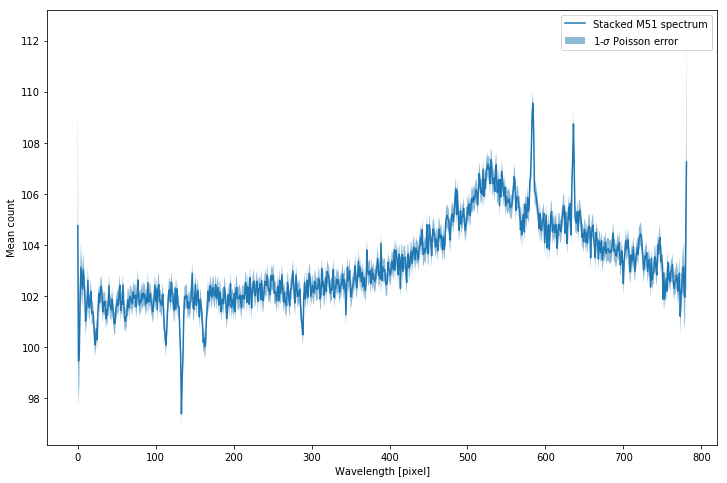

In [12]:
def plot_spectrum(spectrum, counts=None, wavelengths=None, label='Stacked M51 spectrum'):
    fig, ax = plt.subplots(figsize=(12,8))
    
    if wavelengths is None:
        wavelengths = np.arange(len(spectrum))
        xlabel = 'Wavelength [pixel]'
    else:
        xlabel = 'Wavelength [nm]'
    
    ax.plot(wavelengths, spectrum, label=label)
    if counts is not None:
        ax.fill_between(wavelengths, spectrum*(1 - counts**-.5), spectrum*(1 + counts**-.5),
                    alpha=0.5, label=r'1-$\sigma$ Poisson error')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Mean count')
    ax.legend()
    
    return fig, ax
    
plot_spectrum(spectrum, counts)

## Calibration

The last task is to use our measured arc-lamp spectrum to determine a wavelength solution.

Critical: we need to use the same rotation as the M51 spectrum!

In [13]:
hdul_lamp = fits.open('calibration.fit')
lamp = hdul_lamp[0]

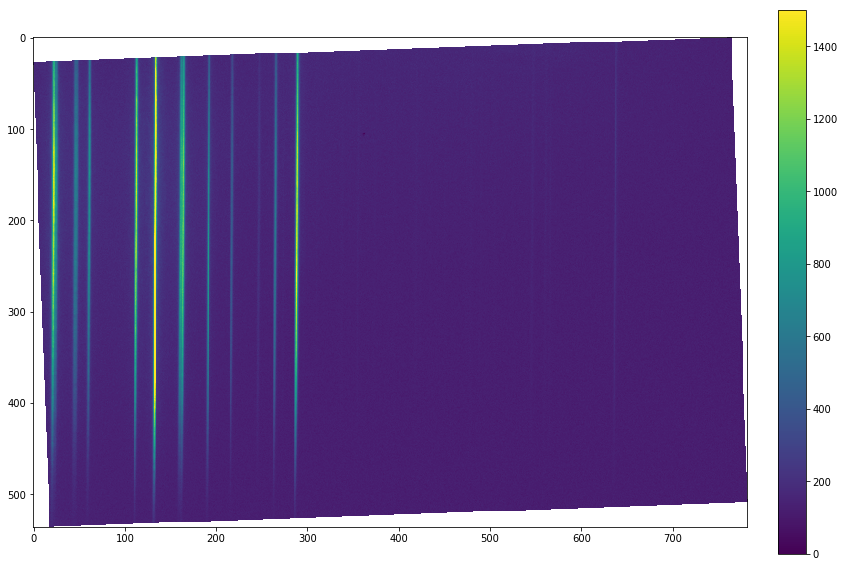

In [14]:
lamp_image = lamp.data.copy()
lamp_image = rotate(lamp_image)
lamp_image = noise_filter(lamp_image, vmin=1, vmax=lamp_image.max())  # just to mask the rotated regions

show_image(lamp_image, labels=False, vmin=0, vmax=1500)

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8f543439e8>)

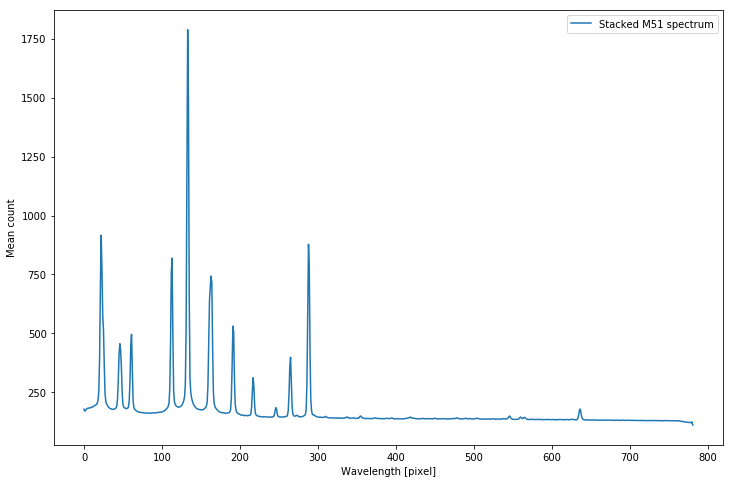

In [15]:
lamp_spectrum = stack(lamp_image)
plot_spectrum(lamp_spectrum)

Now we compare it with the known spectrum.  We're pretty clearly seeing the Argon lines, but in reverse.

Let's use the 696.54 and 811.53 lines.  We can get their positions as the third and second brightest lines.

![lamp_spectrum](CAL_lamp_lines.jpg)

In [16]:
def get_line_center(spectrum, pixmin, pixmax):
    return spectrum[pixmin:pixmax].argmax() + pixmin

line696 = get_line_center(lamp_spectrum, 275, 325)
line811 = get_line_center(lamp_spectrum, 0, 50)

line696, line811

(288, 22)

In [17]:
wavelengths = (np.arange(len(lamp_spectrum)) - line811)*(811.53 - 696.54)/(line811 - line696) + 811.53

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8f4d1a3f28>)

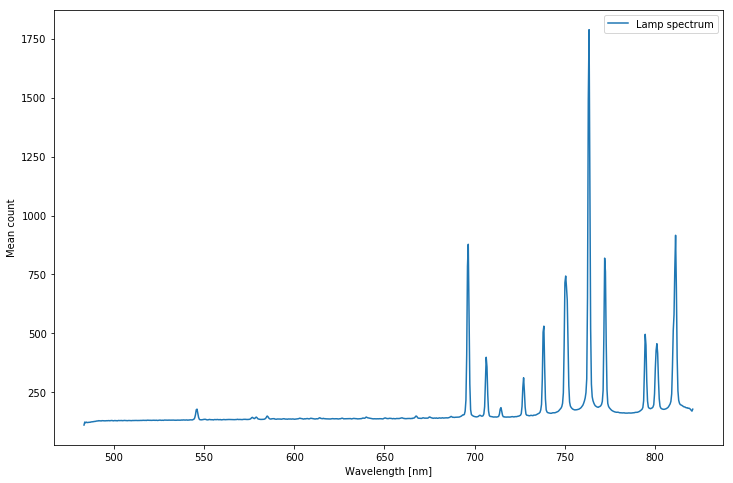

In [18]:
plot_spectrum(lamp_spectrum, wavelengths=wavelengths, label='Lamp spectrum')

Looks good!  Now we can plot the M51 final spectrum:

In [19]:
fig, ax = plot_spectrum(spectrum, counts=counts, wavelengths=wavelengths)

## Identifying features

We can compare our measured spectrum against the known M51 spectrum and sky lines.

A telluric (atmospheric) absorption spectrum is also provided (via http://adsabs.harvard.edu/abs/2003AAS...203.3803H).

To make visual sense of the results, we'll need to degrade the high-quality spectra to match our spectral resolution.

Many thanks to [Ben Johnson](https://www.cfa.harvard.edu/~bdjohnso/) for finding these "known" spectra and helping interpret the results!

In [20]:
import astropy.io.ascii
known_spectrum = astropy.io.ascii.read('NGC_5194_spec.dat')

In [21]:
known_spectrum.meta

OrderedDict([('comments',
              ['An Atlas of Galaxy Spectral Energy Distributions from the Ultraviolet to the Mid-Infrared',
               'Brown et al. (2014)',
               'http://dx.doi.org/10.5072/03/529D3551F0117',
               '',
               'Column 1 : Restframe Wavelength (Angstrom)',
               'Column 2 : Flux per unit wavelength (ergs/s/cm^2/Angstrom)',
               'Column 3 : Observed wavelength (Angstrom)',
               'Column 4 : Source (0 = model, 1 = Optical Spectrum, 2 = Akari, 3 = Spitzer IRS)',
               ''])])

In [22]:
known_spectrum = known_spectrum[known_spectrum['col4'] == 1]

In [23]:
import astropy.table
tellurics = astropy.io.ascii.read('tellurics.csv', fill_values=('-9.99999E+99', '0'))
tellurics['wavelength'] = 1e7/tellurics['wavenumber']

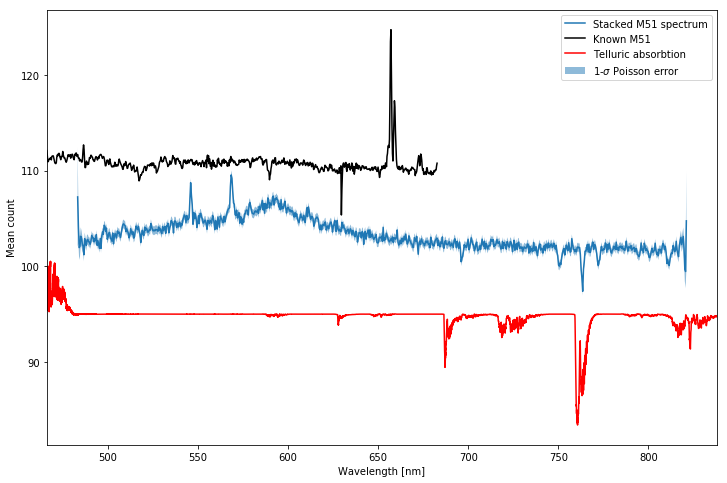

In [24]:
fig, ax = plot_spectrum(spectrum, counts=counts, wavelengths=wavelengths)

from astropy.convolution import convolve, Box1DKernel
k = Box1DKernel(500)  # arbitrary, just to make it look like it matches the res of our M51 spectrum
tellurics['intensity_smoothed'] = convolve(tellurics['intensity'], k)

ax.set_autoscalex_on(False)
ax.plot(known_spectrum['col3']/10, known_spectrum['col2']*2e13 + 100, label='Known M51', c='k')
#ax.set_autoscaley_on(False)
ax.plot(tellurics['wavelength'], tellurics['intensity_smoothed']*15 + 80, label='Telluric absorbtion', c='r')
ax.legend()

Here's a sky emission spectrum measured at Kitt Peak in southern Arizona (from http://adsabs.harvard.edu/abs/2003AAS...203.3803H).  We don't have the raw data, so we'll just include this image for now instead of plotting the spectrum.  We can clearly identify a few features that are shared with our spectrum:

- The high-pressure sodium lamp bump around 6000 Å is also present in our spectrum; the Na D line from low-pressure sodium lamps is not seen.  [Cambridge has replaced many of its HPS lamps with 4000K LED lighting](https://www.cambridgema.gov/~/media/Files/electricaldepartment/LED-Conversion-Fact-Sheet_FINAL.pdf).  The 4000K LED spectrum does seem to peak around 6000 Å (from a cursory search), but with a much broader peak than we're seeing here.

- Near 5577 Å we see a bright line that is probably atmospheric OI
- Near 5461 Å we see a bright line that is probably HgI from mercury vapor street lamps.  Assuming that's a correct identification, it's a little surprising that it's so bright, considering [Boston has mostly phased them out](https://www1.eere.energy.gov/buildings/publications/pdfs/ssl/massaro_msslc-boston2012.pdf).
- There's a pair of small lines near 495 nm and 510 nm in our spectrum.  Maybe HgI and NaI at 4827 and 4983 Å in the Kitt Peak spectrum?

We're missing some notable lines:
- The bright OH lines from 6300 Å to 6600 Å don't seem to show up in our spectrum.

We see some absorption features too:
- The dips at 695 nm and 760 nm match absorption features in the telluric absorption spectrum.  Maybe the one to the right of the 760 nm feature too, although not the one to the left.  820 nm is another match in absportion.

What are we absorbing against?  Unclear.  Lower atmosphere absorbing against upper atmosphere?

![Sky emission](sky_emission.png)